In [ ]:
library(tidyverse)
library(haven)
library(janitor)
library(glmnet)
library(pROC)
library(broom)

# 讀取資料
demo <- read_xpt("DEMO_L.xpt") %>% clean_names()
bmx <- read_xpt("BMX_L.xpt") %>% clean_names()
dr1iff <- read_xpt("DR1IFF_L.xpt") %>% clean_names()
dr2iff <- read_xpt("DR2IFF_L.xpt") %>% clean_names()

# 檢查資料維度
cat("DEMO:", dim(demo), "\n")
cat("BMX:", dim(bmx), "\n")
cat("DR1IFF:", dim(dr1iff), "\n")
cat("DR2IFF:", dim(dr2iff), "\n")


DEMO: 11933 27 
BMX: 8860 22 
DR1IFF: 100116 84 
DR2IFF: 88032 84 


In [ ]:
# ==============================
# Step 2: Join Data
# ==============================

# 先合併 DEMO 和 BMX
dat <- demo %>%
  inner_join(bmx, by = "seqn")

cat("DEMO + BMX:", dim(dat), "\n")

# 再合併 DR1IFF（第一天飲食資料）
dat <- dat %>%
  inner_join(dr1iff, by = "seqn")

cat("DEMO + BMX + DR1IFF:", dim(dat), "\n")
cat("唯一 seqn 數量:", length(unique(dat$seqn)), "\n")
cat("重複的 seqn 數量:", sum(duplicated(dat$seqn)), "\n")


DEMO + BMX: 8860 48 
DEMO + BMX + DR1IFF: 100116 131 
唯一 seqn 數量: 6751 
重複的 seqn 數量: 93365 


In [ ]:
# 排除無用變數
exclude_vars <- c("seqn", "wtdrd1", "wtdr2d", "dr1iline", "dr1drstz", "dr1exmer", 
                  "drabf", "drdint", "dr1dbih", "dr1day", "dr1lang", "dr1mresp", "dr1help",
                  "dr1ccmnm", "dr1ccmtx", "dr1_020", "dr1_030z", "dr1fs", "dr1_040z", 
                  "dr1ifdcd", "dr1igrms")  # dr1ifdcd: 食物代碼, dr1igrms: 食物重量

# 識別營養變數（dr1i 開頭的營養變數）
diet_vars <- names(dat)[grepl("^dr1i", names(dat))]
diet_vars <- setdiff(diet_vars, exclude_vars)

# 只保留必要的變數：seqn, bmxbmi（用來建立 outcome）+ 營養變數
# 任務要求只用 dietary variables 作為 predictors
keep_vars <- c("seqn", "bmxbmi")

# 彙總：只保留 seqn 和 bmxbmi，營養變數加總
dat_summary <- dat %>%
  group_by(seqn) %>%
  summarise(
    bmxbmi = first(bmxbmi),  # BMI 只有一個值
    across(all_of(diet_vars), ~ sum(.x, na.rm = TRUE)),  # 營養變數加總
    .groups = "drop"
  )

cat("彙總前:", nrow(dat), "筆\n")
cat("彙總後:", nrow(dat_summary), "筆\n\n")

cat("=== 保留的變數 ===\n")
cat("必要變數 (2個): seqn, bmxbmi\n")
cat("營養變數 (predictors,", length(diet_vars), "個):\n")
print(diet_vars)
cat("\n最終資料集變數數量:", ncol(dat_summary), "個\n")
cat("  - seqn: ID\n")
cat("  - bmxbmi: 用來建立 outcome\n")
cat("  - 營養變數: 作為 predictors\n")


彙總前: 100116 筆
彙總後: 6751 筆

=== 保留的變數 ===
必要變數 (2個): seqn, bmxbmi
營養變數 (predictors, 65 個):
 [1] "dr1ikcal" "dr1iprot" "dr1icarb" "dr1isugr" "dr1ifibe" "dr1itfat"
 [7] "dr1isfat" "dr1imfat" "dr1ipfat" "dr1ichol" "dr1iatoc" "dr1iatoa"
[13] "dr1iret"  "dr1ivara" "dr1iacar" "dr1ibcar" "dr1icryp" "dr1ilyco"
[19] "dr1ilz"   "dr1ivb1"  "dr1ivb2"  "dr1iniac" "dr1ivb6"  "dr1ifola"
[25] "dr1ifa"   "dr1iff"   "dr1ifdfe" "dr1ichl"  "dr1ivb12" "dr1ib12a"
[31] "dr1ivc"   "dr1ivd"   "dr1ivk"   "dr1icalc" "dr1iphos" "dr1imagn"
[37] "dr1iiron" "dr1izinc" "dr1icopp" "dr1isodi" "dr1ipota" "dr1isele"
[43] "dr1icaff" "dr1itheo" "dr1ialco" "dr1imois" "dr1is040" "dr1is060"
[49] "dr1is080" "dr1is100" "dr1is120" "dr1is140" "dr1is160" "dr1is180"
[55] "dr1im161" "dr1im181" "dr1im201" "dr1im221" "dr1ip182" "dr1ip183"
[61] "dr1ip184" "dr1ip204" "dr1ip205" "dr1ip225" "dr1ip226"

最終資料集變數數量: 67 個
  - seqn: ID
  - bmxbmi: 用來建立 outcome
  - 營養變數: 作為 predictors


In [ ]:
# 移除 BMI 缺失值
dat_final <- dat_summary %>%
  filter(!is.na(bmxbmi))

cat("移除 BMI 缺失值後:", nrow(dat_final), "筆\n")

# 建立 BMI 二元分類變數
# BMI < 25: normal
# BMI >= 25: abnormal
dat_final <- dat_final %>%
  mutate(
    bmi_group = ifelse(bmxbmi < 25, "normal", "abnormal"),
    bmi_group = factor(bmi_group, levels = c("normal", "abnormal"))
  )

cat("\nBMI 分類分布:\n")
print(table(dat_final$bmi_group))
cat("\nBMI 分類比例:\n")
print(prop.table(table(dat_final$bmi_group)))


移除 BMI 缺失值後: 6484 筆

BMI 分類分布:

  normal abnormal 
    2587     3897 

BMI 分類比例:

   normal  abnormal 
0.3989821 0.6010179 


In [ ]:
set.seed(100)
n <- nrow(dat_final)
train_id <- sample(1:n, size = round(0.7 * n))  # 70%當訓練集

train <- dat_final[train_id, ]
test  <- dat_final[-train_id, ]

cat("訓練集大小:", nrow(train), "\n")
cat("測試集大小:", nrow(test), "\n")
cat("\n訓練集 BMI 分類分布:\n")
print(table(train$bmi_group))
cat("\n測試集 BMI 分類分布:\n")
print(table(test$bmi_group))


訓練集大小: 4539 
測試集大小: 1945 

訓練集 BMI 分類分布:

  normal abnormal 
    1801     2738 

測試集 BMI 分類分布:

  normal abnormal 
     786     1159 


使用 10 個營養變數作為 baseline:
 [1] "dr1ikcal" "dr1iprot" "dr1icarb" "dr1isugr" "dr1ifibe" "dr1itfat"
 [7] "dr1isfat" "dr1imfat" "dr1ipfat" "dr1ichol"




Call:
glm(formula = formula_basic, family = binomial, data = train)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.3169491  0.0781895   4.054 5.04e-05 ***
dr1ikcal     0.0008656  0.0002675   3.236 0.001210 ** 
dr1iprot    -0.0005378  0.0019106  -0.281 0.778333    
dr1icarb    -0.0078469  0.0013445  -5.836 5.34e-09 ***
dr1isugr     0.0032143  0.0009485   3.389 0.000702 ***
dr1ifibe     0.0025908  0.0044624   0.581 0.561529    
dr1itfat     0.0158839  0.0159593   0.995 0.319601    
dr1isfat    -0.0295874  0.0185075  -1.599 0.109894    
dr1imfat    -0.0149749  0.0171024  -0.876 0.381248    
dr1ipfat    -0.0182501  0.0166140  -1.098 0.271996    
dr1ichol     0.0004512  0.0001788   2.524 0.011591 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 6097.6  on 4538  degrees of freedom
Residual deviance: 5969.5  on 4528  degrees of freedom
AIC: 5991.5

Number 

Setting levels: control = normal, case = abnormal

Setting direction: controls < cases




基本邏輯迴歸 AUC: 0.5887391 


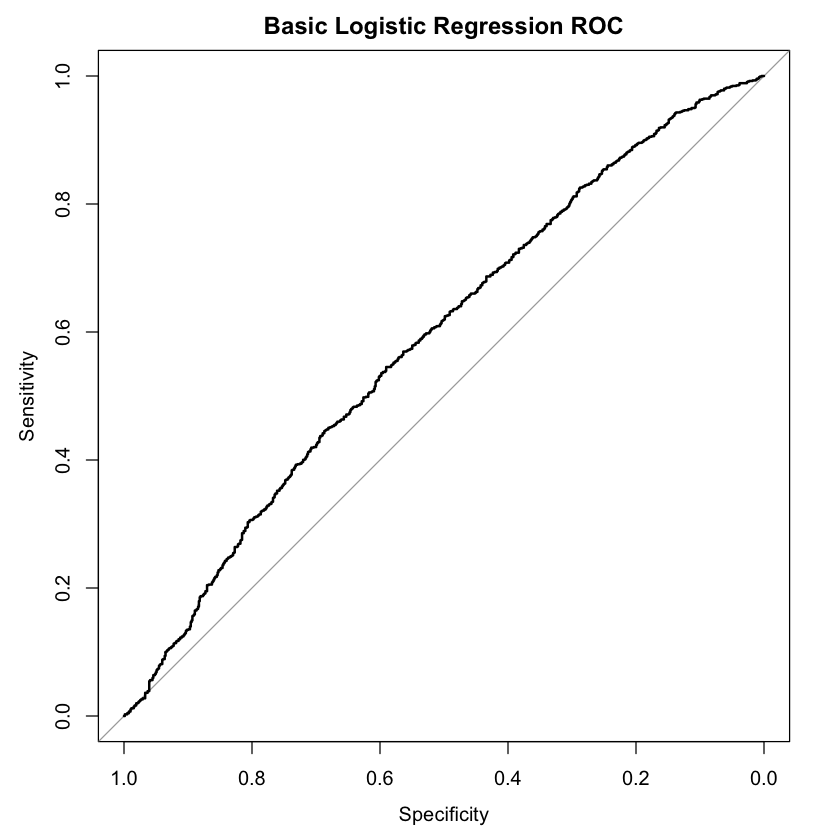

In [ ]:
# 選前 10 個營養變數當示範用 predictor
basic_predictors <- diet_vars[1:10]
cat("使用", length(basic_predictors), "個營養變數作為 baseline:\n")
print(basic_predictors)
cat("\n")

formula_basic <- reformulate(
  termlabels = basic_predictors,
  response   = "bmi_group"
)

model_logit <- glm(formula_basic, data = train, family = binomial)
summary(model_logit)

# 在測試集預測「是 abnormal 的機率」
test$pred_logit_prob <- predict(model_logit, newdata = test, type = "response")

# ROC / AUC
roc_logit <- roc(test$bmi_group, test$pred_logit_prob)
auc_logit <- auc(roc_logit)
cat("\n基本邏輯迴歸 AUC:", as.numeric(auc_logit), "\n")

plot(roc_logit, main = "Basic Logistic Regression ROC")



Call:
glm(formula = formula_full, family = binomial, data = train)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -6.289e-02  9.180e-02  -0.685 0.493285    
dr1ikcal    -5.862e-03  2.661e-03  -2.203 0.027599 *  
dr1iprot     2.820e-02  1.202e-02   2.347 0.018905 *  
dr1icarb     1.846e-02  1.086e-02   1.699 0.089261 .  
dr1isugr     3.843e-03  1.490e-03   2.580 0.009875 ** 
dr1ifibe     3.251e-03  8.371e-03   0.388 0.697753    
dr1itfat     6.711e-02  3.209e-02   2.092 0.036463 *  
dr1isfat    -1.002e-01  7.399e-02  -1.354 0.175763    
dr1imfat    -1.863e-01  9.750e-02  -1.910 0.056079 .  
dr1ipfat     5.272e-02  1.174e-01   0.449 0.653459    
dr1ichol     9.343e-04  5.793e-04   1.613 0.106769    
dr1iatoc     2.705e-02  1.444e-02   1.873 0.061081 .  
dr1iatoa    -1.310e-02  1.882e-02  -0.696 0.486423    
dr1iret      7.221e-02  1.669e-02   4.325 1.52e-05 ***
dr1ivara    -7.226e-02  1.671e-02  -4.324 1.53e-05 ***
dr1iacar     3.010e-03  7.039e-04   4

Setting levels: control = normal, case = abnormal

Setting direction: controls < cases




完整邏輯迴歸 - 訓練集 AUC: 0.7090793 


Setting levels: control = normal, case = abnormal

Setting direction: controls < cases



完整邏輯迴歸 - 測試集 AUC: 0.6924369 

AUC 差異 (訓練集 - 測試集): 0.01664244 


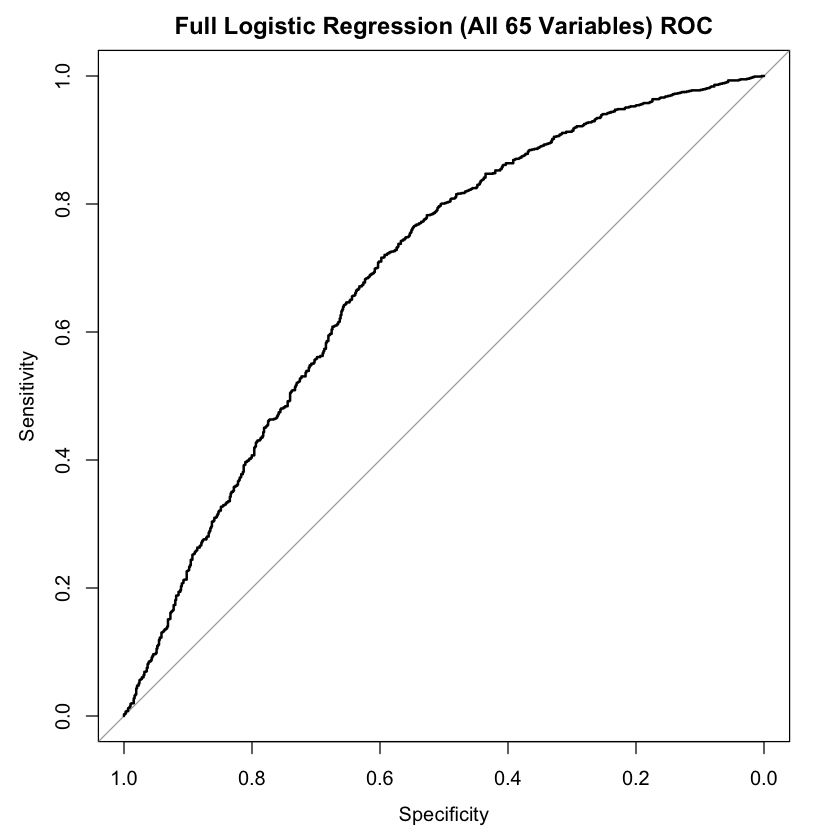

In [26]:
# 使用所有 65 個營養變數
full_predictors <- diet_vars  # 所有營養變數

formula_full <- reformulate(
  termlabels = full_predictors,
  response   = "bmi_group"
)

model_full <- glm(formula_full, data = train, family = binomial)
summary(model_full)

# 訓練集預測
train$pred_full_prob <- predict(model_full, type = "response")
roc_full_train <- roc(train$bmi_group, train$pred_full_prob)
auc_full_train <- auc(roc_full_train)
cat("\n完整邏輯迴歸 - 訓練集 AUC:", as.numeric(auc_full_train), "\n")

# 測試集預測
test$pred_full_prob <- predict(model_full, newdata = test, type = "response")
roc_full_test <- roc(test$bmi_group, test$pred_full_prob)
auc_full_test <- auc(roc_full_test)
cat("完整邏輯迴歸 - 測試集 AUC:", as.numeric(auc_full_test), "\n")

# 比較：如果訓練集 AUC 明顯高於測試集，表示 overfitting
cat("\nAUC 差異 (訓練集 - 測試集):", as.numeric(auc_full_train) - as.numeric(auc_full_test), "\n")

plot(roc_full_test, main = "Full Logistic Regression (All 65 Variables) ROC")


lambda.min: 0.006026535 
lambda.1se: 0.01676919 


Setting levels: control = normal, case = abnormal

Setting direction: controls < cases




LASSO 邏輯迴歸 AUC: 0.6856518 


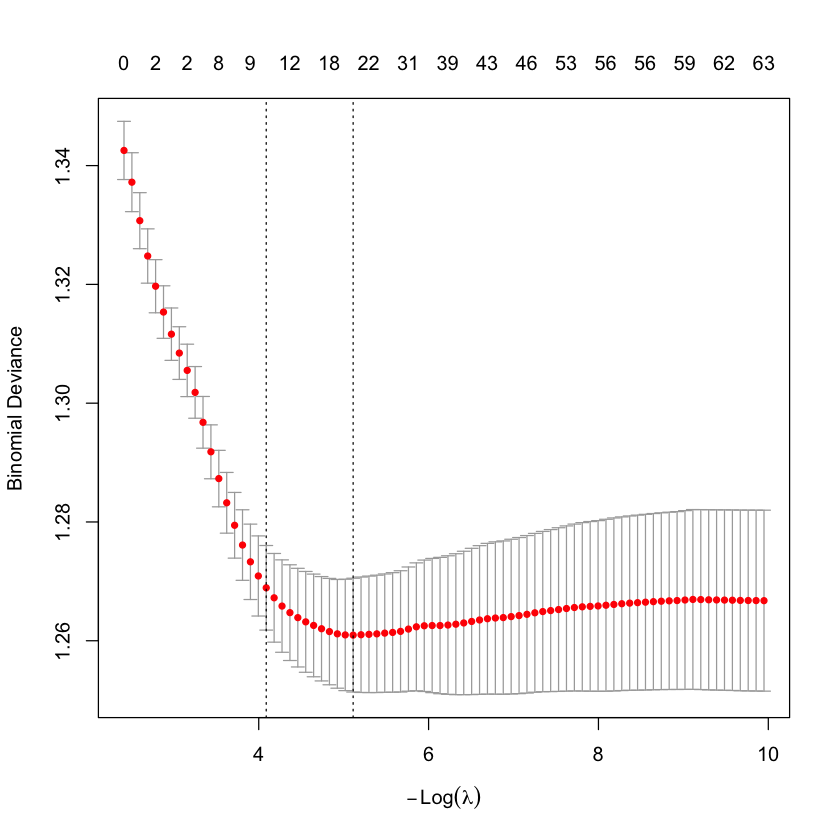

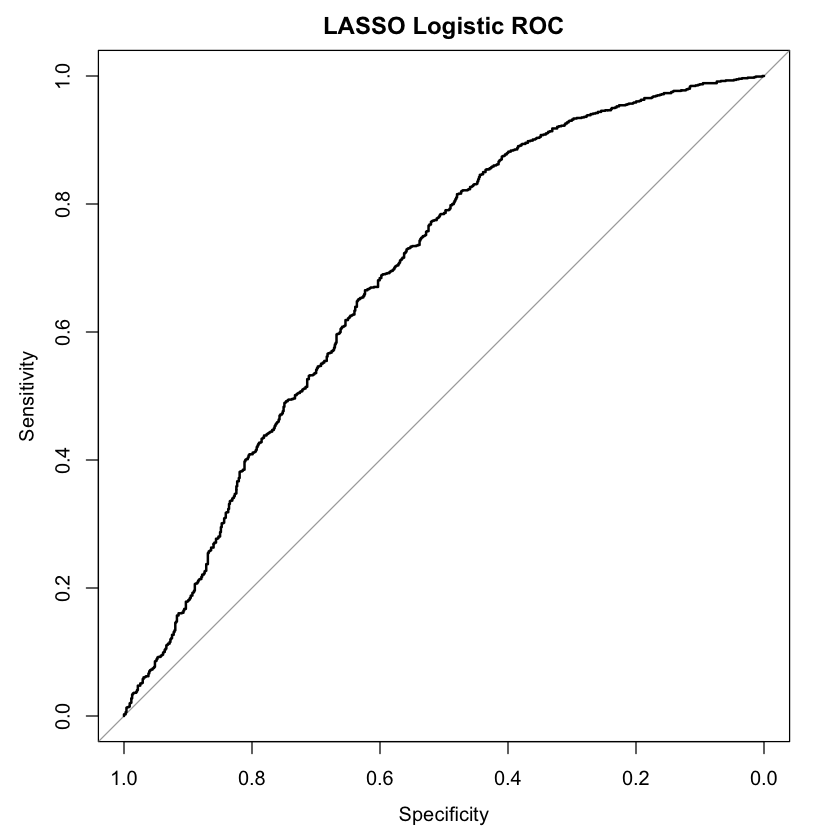

In [ ]:
# 準備 X 和 y 矩陣（glmnet 需要）
x_train <- as.matrix(train[, diet_vars])
x_test  <- as.matrix(test[, diet_vars])

y_train <- train$bmi_group
y_test  <- test$bmi_group

set.seed(123)

# Cross-validation 選擇最佳 lambda
cv_lasso <- cv.glmnet(
  x = x_train,
  y = y_train,
  family = "binomial",
  alpha = 1,      # 1 = LASSO
  nfolds = 5
)

plot(cv_lasso)
cat("lambda.min:", cv_lasso$lambda.min, "\n")
cat("lambda.1se:", cv_lasso$lambda.1se, "\n")

# 在測試集預測（使用 lambda.min）
test$pred_lasso_prob <- predict(
  cv_lasso,
  newx = x_test,
  s = "lambda.min",
  type = "response"
)

# ROC / AUC
roc_lasso <- roc(test$bmi_group, as.numeric(test$pred_lasso_prob))
auc_lasso <- auc(roc_lasso)
cat("\nLASSO 邏輯迴歸 AUC:", as.numeric(auc_lasso), "\n")

plot(roc_lasso, main = "LASSO Logistic ROC")


In [30]:
# ==============================
# Step 9: 比較三個模型的 AUC
# ==============================

tibble(
  model = c("Basic logistic (10 variables)", 
            "Full logistic (65 variables)", 
            "LASSO (65 variables)"),
  AUC   = c(as.numeric(auc_logit), 
            as.numeric(auc_full_test), 
            as.numeric(auc_lasso))
)


model,AUC
<chr>,<dbl>
Basic logistic (10 variables),0.5887391
Full logistic (65 variables),0.6924369
LASSO (65 variables),0.6856518


In [ ]:
# 1) basic model BIC
bic_basic <- BIC(model_logit)

# 2) full model BIC
bic_full <- BIC(model_full)

# 3) LASSO：用選出的變數 refit 一個 logistic 再算 BIC

# 抽出 lambda.min 的 LASSO 係數
coef_min <- coef(cv_lasso, s = "lambda.min")

coef_lasso_df <- tibble(
  var  = rownames(coef_min),
  coef = as.numeric(coef_min)
)

# 過濾掉 Intercept 與係數 = 0
nonzero_coef <- coef_lasso_df %>% 
  filter(var != "(Intercept)", coef != 0)

cat("LASSO 選出的非零係數變數數量:", nrow(nonzero_coef), "\n\n")
print(nonzero_coef)

lasso_vars <- nonzero_coef$var

formula_lasso_refit <- reformulate(
  termlabels = lasso_vars,
  response   = "bmi_group"
)

model_lasso_refit <- glm(formula_lasso_refit, data = train, family = binomial)

bic_lasso <- BIC(model_lasso_refit)

tibble(
  model = c("Basic logistic (10 variables)",
            "Full logistic (65 variables)",
            "LASSO refit"),
  BIC   = c(bic_basic, bic_full, bic_lasso)
)


LASSO 選出的非零係數變數數量: 20 

# A tibble: 20 × 2
   var             coef
   <chr>          <dbl>
 1 dr1icarb -0.00157   
 2 dr1ichol  0.000428  
 3 dr1ilz   -0.00000661
 4 dr1ivb1  -0.0750    
 5 dr1ifa   -0.000242  
 6 dr1ivb12  0.00931   
 7 dr1ivc   -0.00105   
 8 dr1ivd   -0.0285    
 9 dr1icalc -0.0000834 
10 dr1imagn -0.0000591 
11 dr1icaff  0.00188   
12 dr1itheo -0.000757  
13 dr1imois  0.000260  
14 dr1is080 -0.0834    
15 dr1is180  0.0125    
16 dr1im161  0.00699   
17 dr1im201  0.0677    
18 dr1ip183  0.0252    
19 dr1ip204  1.53      
20 dr1ip225  0.236     


model,BIC
<chr>,<dbl>
Basic logistic (10 variables),6062.076
Full logistic (65 variables),6114.795
LASSO refit,5830.376


### 資料分析總結：使用飲食變數預測 BMI 分類

使用 NHANES 資料集進行二元分類：
- **Outcome**: BMI 分類（normal: BMI < 25, abnormal: BMI ≥ 25）
- **Predictors**: 65 個飲食營養變數
- **目標**: 比較不同建模方法的預測效果

#### 資料處理

- 合併 DEMO、BMX、DR1IFF 三個資料集（以 `seqn` 為鍵）
- 處理重複測量：每人多筆食物記錄彙總為每日總營養攝取量
- 最終資料：6,484 筆（移除 BMI 缺失值後）
- 訓練/測試集分割：70% / 30%

#### 模型比較結果

##### 預測表現（AUC）

- **Basic logistic**：10 個變數，測試集 AUC = 0.589
- **Full logistic**：65 個變數，測試集 AUC = 0.692
- **LASSO**：20 個變數（選出），測試集 AUC = 0.686

#### 主要發現

1. **Overfitting 現象**
   - Full logistic 訓練集 AUC (0.709) > 測試集 AUC (0.692)
   - AUC 差異：0.017，顯示輕微 overfitting

2. **LASSO 變數選擇**
   - 從 65 個變數中自動選出 20 個重要變數
   - 預測表現 (AUC = 0.686) 接近 Full logistic，但使用更少變數

3. **模型複雜度**
   - Basic logistic 表現最差（AUC = 0.589），變數太少
   - Full logistic 與 LASSO 表現相近，但 LASSO 模型更簡潔

#### 結論

- **LASSO 表現最佳**：在預測表現與模型簡潔性之間取得平衡
- 當變數數量較多時，正則化方法（LASSO）能有效避免 overfitting
- 飲食變數對 BMI 分類有一定預測能力，但預測效果中等（AUC < 0.7）